In [2]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv("../dataset/AND_dataset/AND_dataset/AND_features.csv")
data = data.iloc[:,1:]

In [26]:
from pgmpy.estimators import HillClimbSearch, K2Score
import networkx as nx
import pylab as plt

In [4]:
def genPositiveData(data):
    skeleton = pd.DataFrame()
    writers = np.unique(data.ImageId)
    for writer in writers:
        query = str("ImageId == '"+str(writer)+"'")
        test = data.query(str(query))
        data1 = test.sample(frac=1)
        data1 = data1.add_prefix('w1_')
        data2 = test.sample(frac=1)
        data2 = data2.add_prefix('w2_')
        test = pd.concat([data1.reset_index(drop=True),data2.reset_index(drop=True)],axis=1)
        skeleton = skeleton.append(test)
    return skeleton

def genNegativeData(data):
    data1 = data.sample(frac=1)
    data1 = data1.add_prefix('w1_')
    data2 = data.sample(frac=1)
    data2 = data2.add_prefix('w2_')
    negSamples = pd.concat([data1.reset_index(drop=True),data2.reset_index(drop=True)],axis=1)
    return negSamples

In [16]:
skeleton = pd.DataFrame()
while(True):
    samples = len(skeleton)
    posData = genPositiveData(data)
    negData = genNegativeData(data)
    temp = negData.append(posData).reset_index(drop=True)
    skeleton = temp.append(skeleton)
    print(samples)
    if samples > 10000:
        break;

0
2052
4104
6156
8208
10260


In [17]:
bigBadDataset = skeleton

In [18]:
bigBadDataset["sameWriter"]=0

In [19]:
bigBadDataset.sameWriter  = np.where(bigBadDataset["w1_ImageId"] == bigBadDataset["w2_ImageId"],1,0)

In [20]:
bigBadDataset = bigBadDataset.drop(["w1_ImageId","w2_ImageId"],axis=1)

In [21]:
bigBadDataset.w1_f9 = bigBadDataset.w1_f9 - 1

In [22]:
bigBadDataset.w2_f9 = bigBadDataset.w2_f9 - 1

In [23]:
sameWriterHypothesis = len(bigBadDataset.query('sameWriter == 1' )) / len(bigBadDataset)
print(sameWriterHypothesis)
diffWriterHypothesis = len(bigBadDataset.query('sameWriter == 0' )) / len(bigBadDataset)
print(diffWriterHypothesis)

0.5003248862897985
0.4996751137102014


In [24]:
est = HillClimbSearch(bigBadDataset, scoring_method=K2Score(bigBadDataset))
ssj3Model = est.estimate(max_indegree=3)

AttributeError: module 'matplotlib.pyplot' has no attribute 'ishold'

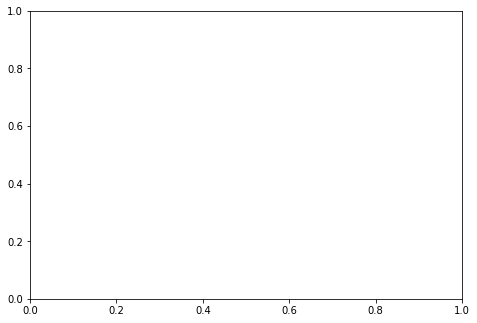

In [28]:
nx.draw(ssj3Model, with_labels=True)
plt.show()

In [35]:
from pgmpy.estimators import MaximumLikelihoodEstimator

In [36]:
mle = MaximumLikelihoodEstimator(ssj3Model, bigBadDataset)
for var in bigBadDataset.columns:
    ssj3Model.add_cpds(mle.estimate_cpd(var))

In [ ]:
from pgmpy.readwrite import BIFWriter

In [ ]:
model_data = BIFWriter(ssj4Model)
model_data.write_bif(filename='ssj4Model.bif')

In [ ]:
bigBadDataset

In [31]:
from pgmpy.inference import VariableElimination

In [39]:
inference = VariableElimination(ssj3Model)

In [38]:
3 	1 	0 	2 	2 	2 	0 	0 	1 	2 	4 	1 	4 	2 	2 	0 	2 	1 	

SyntaxError: invalid syntax (<ipython-input-38-eba7dccd9658>, line 1)

In [40]:
test = inference.query(variables=['sameWriter'],evidence={'w1_f1':3, 'w1_f2':1, 'w1_f3':0, 'w1_f4':2, 'w1_f5':2, 'w1_f6':2, 'w1_f7':0, 'w1_f8':0, 'w1_f9':1, 'w2_f1':2, 'w2_f2':4, 'w2_f3':1, 'w2_f4':4,'w2_f5':2,'w2_f6':2,'w2_f7':0,'w2_f8':2,'w2_f9':1})

In [41]:
print(test['sameWriter'])

+--------------+-------------------+
| sameWriter   |   phi(sameWriter) |
+==============+===================+
| sameWriter_0 |            1.0000 |
+--------------+-------------------+
| sameWriter_1 |            0.0000 |
+--------------+-------------------+


In [ ]:
acc = 0
for rows in range(len(bigBadDataset)):
    inf = inference.query(variables=['sameWriter'],evidence=
               dict(zip(bigBadDataset.columns[:18],list(bigBadDataset.iloc[rows,:18]))))
    if np.argmax(inf['sameWriter'].values) == int(bigBadDataset.iloc[rows,18:]):
        acc +=1

In [ ]:
acc/len(bigBadDataset)